<a href="https://colab.research.google.com/github/hemanth346/eva4/blob/master/S5/M5_S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model 5

### Target :

1. Add regularization, Dropout

### Results :
1. Parameters: 9,430
1. Best Train Accuracy: 99.47
1. Best Test Accuracy: 99.46 

### Analysis
1. Achieved target accuracy more consistently for mulitple epochs
1. Good model, can be pushed further if required.


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from IPython.display import Image # to display PIL images


In [0]:
# # dataset - Creating train and test
# train = datasets.MNIST('./data', train=True, download=True)
# test = datasets.MNIST('./data', train=False, download=True)
# # As PIL.Image
# x, y = train[7777]
# print(y)
# display(x)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
# dataset - Creating train and test
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


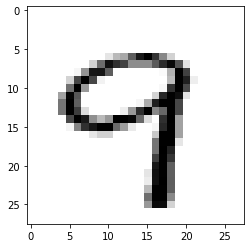

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


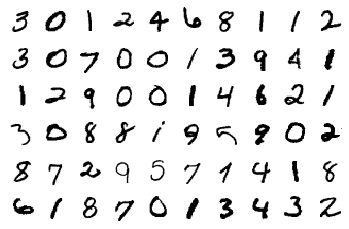

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

In [0]:
def conv_block(in_channels, out_channels, dropout=0,*args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, *args, **kwargs),
        nn.BatchNorm2d(out_channels), # < added this
        nn.ReLU(),
        nn.Dropout(dropout)
        )
    


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = conv_block(in_channels=1, out_channels=10, kernel_size=3, padding=1, dropout=0.01, bias=False) #28, rf 3      
        self.conv2 = conv_block(in_channels=10, out_channels=20, kernel_size=3, dropout=0.01, bias=False) #26, rf 5       
        self.pool = nn.MaxPool2d(2, 2)  #13, rf 6                     
        
        self.conv3 = conv_block(in_channels=20, out_channels=10, kernel_size=3, dropout=0.05, bias=False)  #11, rf 10     
        self.conv4 = conv_block(in_channels=10, out_channels=20, kernel_size=3, dropout=0.05, bias=False)  # 9, rf 14    
        self.conv5 = conv_block(in_channels=20, out_channels=10, kernel_size=3, dropout=0.1, bias=False)  # 7, rf 18   

        # No relu, BN before GAP/Last layer
        self.conv6 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, bias=False) #5, rf 22              

        self.gap = nn.AdaptiveAvgPool2d((1,1)) #1, rf 30                                                                   
        self.pconv1 = nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1, bias=False) #1, rf 30     

    def forward(self, x):
        x = self.pool(self.conv2(self.conv1(x)))

        x = self.conv4(self.conv3(x))
        x = self.conv6(self.conv5(x))
        
        x = self.gap(x)
        x = self.pconv1(x)
        x = x.view(-1, 10)

        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 20, 26, 26]           1,800
       BatchNorm2d-6           [-1, 20, 26, 26]              40
              ReLU-7           [-1, 20, 26, 26]               0
           Dropout-8           [-1, 20, 26, 26]               0
         MaxPool2d-9           [-1, 20, 13, 13]               0
           Conv2d-10           [-1, 10, 11, 11]           1,800
      BatchNorm2d-11           [-1, 10, 11, 11]              20
             ReLU-12           [-1, 10, 11, 11]               0
          Dropout-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
model =  Net().to(device)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    if epoch < 8:
        print('Learning rate :',0.03)
        optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
    elif epoch < 11:
        print('Learning rate :',0.003)
        optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    else:
        print('Learning rate :',0.0003)
        optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)

    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
Learning rate : 0.03


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.0242120623588562 Batch_id=468 Accuracy=91.00: 100%|██████████| 469/469 [00:10<00:00, 44.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0834, Accuracy: 9733/10000 (97.33%)

EPOCH: 1
Learning rate : 0.03


Loss=0.12144201993942261 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:10<00:00, 43.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9851/10000 (98.51%)

EPOCH: 2
Learning rate : 0.03


Loss=0.04600754380226135 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:10<00:00, 45.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9877/10000 (98.77%)

EPOCH: 3
Learning rate : 0.03


Loss=0.12760722637176514 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:10<00:00, 44.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9915/10000 (99.15%)

EPOCH: 4
Learning rate : 0.03


Loss=0.013178895227611065 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:10<00:00, 42.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9894/10000 (98.94%)

EPOCH: 5
Learning rate : 0.03


Loss=0.05003270506858826 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:10<00:00, 45.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9898/10000 (98.98%)

EPOCH: 6
Learning rate : 0.03


Loss=0.046289458870887756 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:10<00:00, 45.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9914/10000 (99.14%)

EPOCH: 7
Learning rate : 0.03


Loss=0.10795684903860092 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:10<00:00, 44.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9909/10000 (99.09%)

EPOCH: 8
Learning rate : 0.003


Loss=0.016413599252700806 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:10<00:00, 44.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)

EPOCH: 9
Learning rate : 0.003


Loss=0.0030380587559193373 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:10<00:00, 43.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

EPOCH: 10
Learning rate : 0.003


Loss=0.014284948818385601 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:10<00:00, 44.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 11
Learning rate : 0.0003


Loss=0.007058972958475351 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:10<00:00, 44.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 12
Learning rate : 0.0003


Loss=0.0514332540333271 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:10<00:00, 44.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

EPOCH: 13
Learning rate : 0.0003


Loss=0.007116993423551321 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:10<00:00, 44.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)

EPOCH: 14
Learning rate : 0.0003


Loss=0.04237515106797218 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:10<00:00, 44.34it/s]



Test set: Average loss: 0.0185, Accuracy: 9946/10000 (99.46%)



Text(0.5, 1.0, 'Test Accuracy')

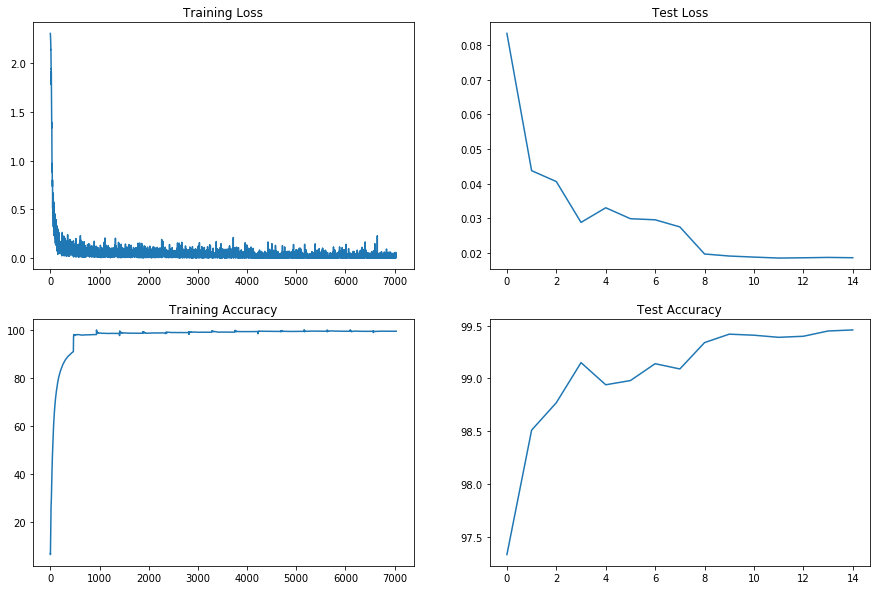

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")